In [1]:
import numpy as np
from PIL import Image, ImageStat
import collections as col

In [2]:
def calc_spx(im):  # suma pikseli, klucz prywatny s-box
    px_sum = 0
    for i in range(0,len(im)):
        for j in range(0,len(im[i])):
            for k in range(0,len(im[i][j])):
                px_sum += im[i][j][k]
    return px_sum

In [3]:
def asymetric_tent_map(xk,p): #funkcja rekurencyjna
    if xk<p and xk>0:
        return (xk/p)
    elif xk<1 and xk>=p:
        return ((1-xk)/(1-p))

In [4]:
def m_map (xk, p): #funkcja rekurencyjna
    if xk<=0.5 and xk>=0:
        return ((xk/p)*(2-(xk/p)))
    elif xk<=1 and xk>0.5:
        return (((1-xk)/p)*(2-((1-xk)/p)))

In [27]:
def generate_sbox(Spx, x, N, M, p):
    sn = list(np.arange(start=0,stop=256,step=1)) #lista [0,1,..,255]
    lengthSn = len(sn)
    sb = []

    #obliczenie wartości początkowej
    initial_val = (x+(Spx/(3*255*N*M)))%1
    
    #opuszczenie tysiąca pierwszych wartości x z rekurencji
    for i in range(10**3):
        initial_val = asymetric_tent_map(initial_val, p)
    
    xs = initial_val

    while lengthSn > 0:
        xs = asymetric_tent_map(xs,p) #calculate x from recurence
        index = (xs*lengthSn)//1 #calculate index
        index = int(index)
        sb.append(sn[index]) #add Sn[index] to Sb
        sn.pop(index) #remove from Sn element Sn[index]
        lengthSn -= 1 #decrease lengthSn by 1
        
    return sb

In [28]:
def encryption1(im, x, p):
    I = np.asarray(im)
    N, M = im.size #szerokość, wysokość
    
    #obliczenie wartości klucza Spx
    Spx = calc_spx(I)
    print(Spx)
        
    sb = generate_sbox(Spx, x, N, M, p)
    
    xk = x
    first_place = []
    last_place = []

    deque_sb = col.deque(sb) #zmiana typu "listy" żeby szybciej wykonywał się obrót cykliczny s-box

    for i in range(M): #po wierszach obrazu
        for j in range(N): #po kolumnach obrazu
            xk = m_map(xk,p) #calculate xk from m_map

            #Read the S − box value for the pixels RGB components (S − box(px(i,j)));
            new_px_vals = [deque_sb[I[i][j][0]],deque_sb[I[i][j][1]],deque_sb[I[i][j][2]]] 

            if xk <= 0.5:
                first_place.append(new_px_vals) #write value S − box(px(i,j)) in the first free place
            elif xk > 0.5:
                last_place.append(new_px_vals) #write value S − box(px(i,j)) in the last free place

            shift = int((256*xk)//1) #calculate shift
            deque_sb.rotate(shift) #shift s-box
            
    #połączenie w całość pikseli zapisywanych od końca i od początku
    last_place_rv = last_place[::-1]
    first_place.extend(last_place_rv)
    
    #utworzenie nowej listy pikseli (zaszyfrowanych)
    px_list = []
    
    #zmiana budowy listy, by móc ją wczytać jako obraz rgb
    for i in range(M):
        px_list.append([])
        for j in range(N):
            px_list[i].append(first_place[(i*M)+j])
    
    #zapisanie listy jako obraz
    enc_im = Image.fromarray(np.uint8(px_list))
    
    return enc_im

In [33]:
def decryption1(enc_im, x, p, enc_spx):
    J = np.asarray(enc_im)
    enc_N, enc_M = enc_im.size
    
    J_flatter = J.reshape(enc_N*enc_M,3) #zmiana struktury na listę pikseli
    J_flatter
    
    sb = generate_sbox(enc_spx, x, enc_N, enc_M, p)
    
    px_list2 = []
    xk2 = x
    
    deque_sb = col.deque(sb) #zmiana typu "listy" żeby szybciej wykonywał się obrót cykliczny s-box

    while len(J_flatter)>0:
        xk2 = m_map(xk2,p) #calculate x from recurence

        if xk2 <= 0.5: #pierwszy nieodczytany piksel
            px = J_flatter[0]
            J_flatter = np.delete(J_flatter, 0, 0)
        elif xk2 > 0.5: #ostatni nieodczytany piksel
            px = J_flatter[len(J_flatter)-1]
            J_flatter = np.delete(J_flatter, len(J_flatter)-1, 0)

        pixels = []

        for i in px: #dla każdej z wartości rgb danego piksela
            px_index = deque_sb.index(int(i)) #znalezienie pod którym indeksem leży dana wartość rgb
            pixels.append(px_index)
        px_list2.append(pixels) #dodanie nowych (odszyfrowanych) wartości pikseli do listy

        shift = int((256*xk2)//1) #obliczenie wartości shift
        deque_sb.rotate(shift) #shift s-box
        
    #zmiana struktury listy, by móc ją potem odczytać jako obraz
    decode_px = []
    for i in range(enc_M):
        decode_px.append([])
        for j in range(enc_N):
            decode_px[i].append(px_list2[(i*enc_M)+j])
            
    im2 = Image.fromarray(np.uint8(decode_px))
    return im2    

In [34]:
im1 = Image.open("lena.jpg")

In [35]:
x1 = 0.789
p1 = 0.352
enc_im1 = encryption1(im1, x1, p1)

100837637


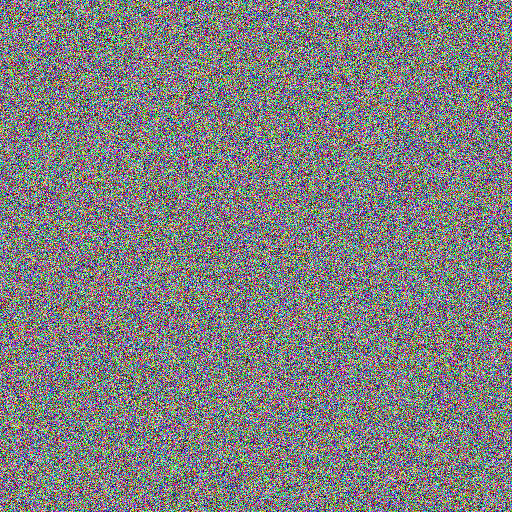

In [39]:
enc_im1

In [36]:
im2 = decryption1(enc_im1, x1, p1, 100837637)

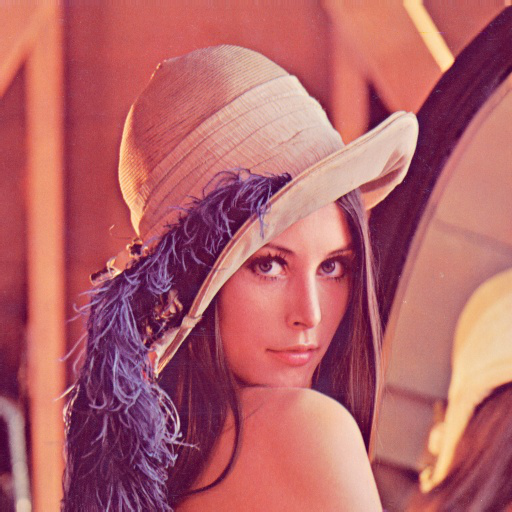

In [37]:
im2

In [40]:
import matplotlib.pyplot as plt
def draw_histograms(im): #rysowanie histogramów
    plt.hist([x[0] for x in list(im.getdata())], bins = 256, color = 'tab:red')
    plt.ylim((0,4000))
    plt.show()
    plt.hist([x[1] for x in list(im.getdata())], bins = 256, color = 'tab:green')
    plt.ylim((0,4000))
    plt.show()
    plt.hist([x[2] for x in list(im.getdata())], bins = 256, color = 'tab:blue')
    plt.ylim((0,4000))
    plt.show()

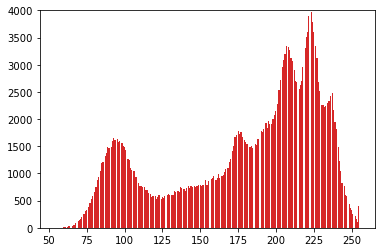

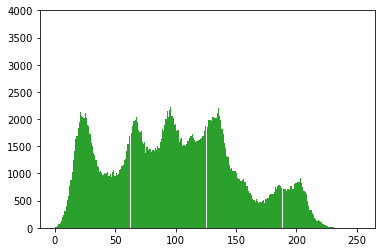

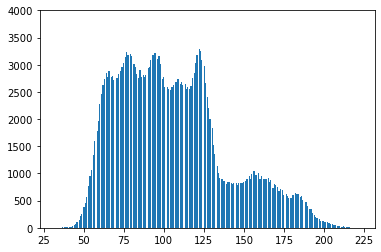

In [41]:
draw_histograms(im1)

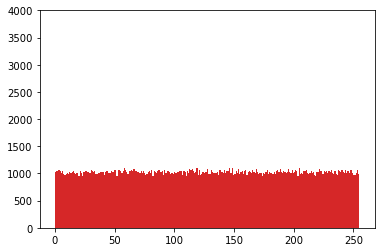

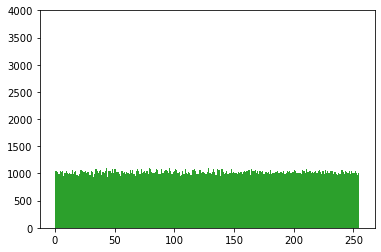

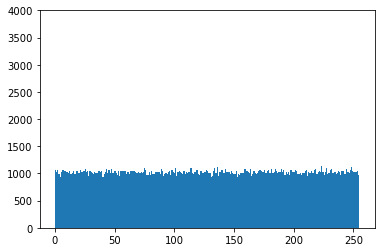

In [42]:
draw_histograms(enc_im1)

In [43]:
def key_sensitivity(im, x, p, change_value):
    
    im_oryg = encryption1(im, x, p)
    im_x = encryption1(im, x+change_value, p)
    im_p = encryption1(im, x, p+change_value)
    
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(im_oryg)
    
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(im_x)
    
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(im_p)

100837637
100837637
100837637


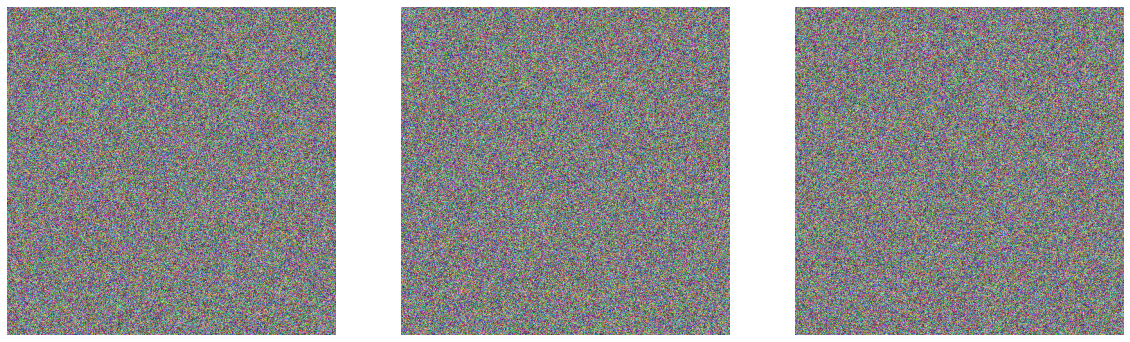

In [44]:
key_sensitivity(im1, x1, p1, 10**(-16))

In [45]:
# Differential Attack

In [46]:
import random

In [47]:
def npcr(im, x, p):
    N, M = im.size #szerokość, wysokość
    im2 = im.copy()
    im2_px = im2.load()
    random_N = random.randint(0, N-1)
    random_M = random.randint(0, M-1)
    im2_px[random_N, random_M] = ((im2_px[random_N, random_M][0]+1)%256, (im2_px[random_N, random_M][1]+1)%256, (im2_px[random_N, random_M][2]+1)%256)
    
    enc_im = encryption1(im, x, p)
    enc_im2 = encryption1(im2, x, p)
    
    enc_px = list(enc_im.getdata())
    enc_px2 = list(enc_im2.getdata())
    
    res = []
    
    for i in range(0,3): #dla każdego kanału RGB
        dif_sum = 0 
        for j in range(len(enc_px)): #obliczenie sumy ze wzoru
            if enc_px[j][i] != enc_px2[j][i]:
                dif_sum += 1
        
        res.append(round((dif_sum/(N*M))*100,4))
        
    return res

In [62]:
# im = im1
# N, M = im.size #szerokość, wysokość
# im2 = im.copy()
# im2_px = im2.load()
# random_N = random.randint(0, N-1)
# random_M = random.randint(0, M-1)
# im2_px[random_N, random_M] = ((im2_px[random_N, random_M][0]+1)%256, (im2_px[random_N, random_M][1]+1)%256, (im2_px[random_N, random_M][2]+1)%256)
    
# enc_im = encryption1(im, x1, p1)
# enc_im2 = encryption1(im2, x1, p1)
    

In [49]:
def npcr2(im1, im2):
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)
    values = [0,0,0]
    for i in range(len(im1)):
        for j in range(len(im1[i])):
            for k in range(len(im1[i][j])):
                if im1[i][j][k] != im2[i][j][k]:
                    values[k]+=1
    length = im1.size/3
    values = [(x/length) * 100 for x in values]
    return values

In [50]:
npcr2(enc_im, enc_im2)

[100.0, 100.0, 100.0]

In [51]:
npcr_res = npcr(im1, x1, p1)

100837637
100837640


In [52]:
npcr_res

[100.0, 100.0, 100.0]

In [53]:
def uaci(im, x, p):
    N, M = im.size #szerokość, wysokość
    im2 = im.copy()
    im2_px = im2.load()
    random_N = random.randint(0, N-1)
    random_M = random.randint(0, M-1)
    im2_px[random_N, random_M] = ((im2_px[random_N, random_M][0]+1)%256, (im2_px[random_N, random_M][1]+1)%256, (im2_px[random_N, random_M][2]+1)%256)
    
    enc_im = encryption1(im, x, p)
    enc_im2 = encryption1(im2, x, p)
    
    enc_px = list(enc_im.getdata())
    enc_px2 = list(enc_im2.getdata())
    
    res = []
    
    for i in range(0,3): #dla każdego kanału RGB
        dif_sum = 0 
        for j in range(len(enc_px)): #obliczenie sumy ze wzoru
            dif_sum += (abs(enc_px[j][i] - enc_px2[j][i])/255)
        
        res.append(round((dif_sum/(N*M))*100,2))
    return res

In [54]:
uaci_res = uaci(im1, x1, p1)

100837637
100837640


In [55]:
uaci_res

[33.09, 33.15, 33.14]

In [56]:
from math import log2, sqrt

In [57]:
def Entropy(image): #entropia
    r, g, b = image.split()
    
    results = []
    
    for i in (r,g,b):
        i = i.histogram()
        sum_channel = 0
        
        for j in i:
            sum_channel += - (j/sum(i))*(log2(j/sum(i)))
            
        results.append(round(sum_channel,4))
    return results

In [58]:
res_entropy = Entropy(enc_im1)
print(res_entropy)

[7.9993, 7.9993, 7.9992]


In [59]:
def correlations(im, x, p, encrypted = 1):
    
    if encrypted == 1:
        im = encryption1(im, x, p)
    
    N, M = im.size
    r = []
        
    #horizontal
    im21 = im.crop((0,0,N-1,M))
    im22 = im.crop((1,0,N,M))
    
    stat21 = ImageStat.Stat(im21)
    stat22 = ImageStat.Stat(im22)
    stat21_mean = stat21.mean
    stat22_mean = stat22.mean
    
    im21_px = im21.load()
    im22_px = im22.load()
    
    r_temp = []
    for k in range(3):
        cov = 0
        var21 = 0
        var22 = 0
        for i in range(M):
            for j in range(N-1):
                var21 += (im21_px[j,i][k] - stat21_mean[k])**2
                var22 += (im22_px[j,i][k] - stat22_mean[k])**2
                cov += (im21_px[j,i][k] - stat21_mean[k])*(im22_px[j,i][k] - stat22_mean[k])
                
        cov = cov/N
        sigma21 = sqrt(var21/N)
        sigma22 = sqrt(var22/N)
        r_value = cov/(sigma21*sigma22)
        r_temp.append(round(r_value,4))
    r.append(r_temp)
    
    #vertical
    im31 = im.crop((0,0,N,M-1))
    im32 = im.crop((0,1,N,M))
    
    stat31 = ImageStat.Stat(im31)
    stat32 = ImageStat.Stat(im32)
    stat31_mean = stat31.mean
    stat32_mean = stat32.mean
    
    im31_px = im31.load()
    im32_px = im32.load()
    
    r_temp = []
    for k in range(3):
        cov = 0
        var31 = 0
        var32 = 0
        for i in range(M-1):
            for j in range(N):
                var31 += (im31_px[j,i][k] - stat31_mean[k])**2
                var32 += (im32_px[j,i][k] - stat32_mean[k])**2
                cov += (im31_px[j,i][k] - stat31_mean[k])*(im32_px[j,i][k] - stat32_mean[k])
                
        cov = cov/N
        sigma31 = sqrt(var31/N)
        sigma32 = sqrt(var32/N)
        r_value = cov/(sigma31*sigma32)
        r_temp.append(round(r_value,4))
    r.append(r_temp)
    
    #diagonal
    im41 = im.crop((0,0,N-1,M-1))
    im42 = im.crop((1,1,N,M))
    
    stat41 = ImageStat.Stat(im41)
    stat42 = ImageStat.Stat(im42)
    stat41_mean = stat41.mean
    stat42_mean = stat42.mean
    
    im41_px = im41.load()
    im42_px = im42.load()
    
    r_temp = []
    for k in range(3):
        cov = 0
        var41 = 0
        var42 = 0
        for i in range(M-1):
            for j in range(N-1):
                var41 += (im41_px[j,i][k] - stat41_mean[k])**2
                var42 += (im42_px[j,i][k] - stat42_mean[k])**2
                cov += (im41_px[j,i][k] - stat41_mean[k])*(im42_px[j,i][k] - stat42_mean[k])
                
        cov = cov/N
        sigma41 = sqrt(var41/N)
        sigma42 = sqrt(var42/N)
        r_value = cov/(sigma41*sigma42)
        r_temp.append(round(r_value,4))
    r.append(r_temp)
      
    return r

In [60]:
r = correlations(im1, x1, p1, 1)

100837637


In [61]:
r

[[0.0013, 0.0009, 0.0024],
 [0.0036, 0.0024, 0.0019],
 [-0.0009, -0.0005, -0.0015]]

In [63]:
# na innym obrazie

In [72]:
im22 = Image.open('airplane.jpg')

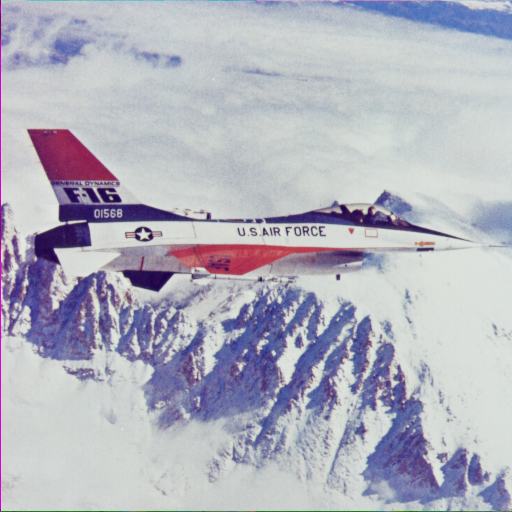

In [73]:
im22

In [74]:
x22 = 0.789
p22 = 0.352
enc_im22 = encryption1(im22, x22, p22)

143037125


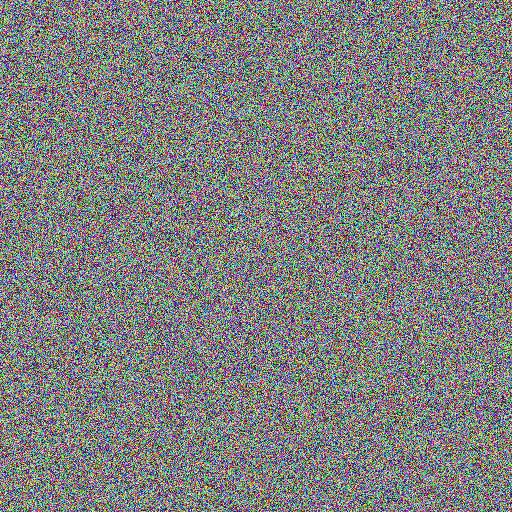

In [75]:
enc_im22

In [78]:
im23 = decryption1(enc_im22, x22, p22, 143037125)

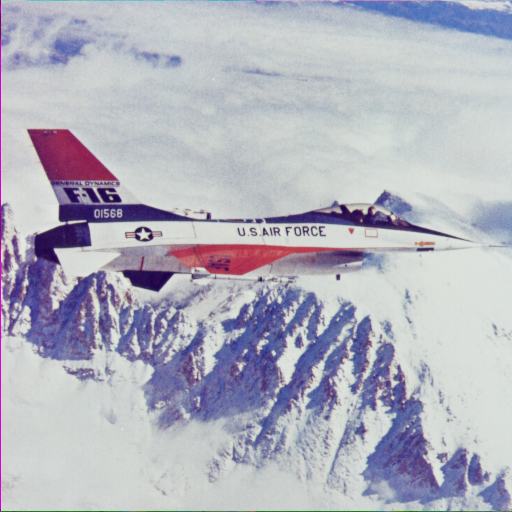

In [79]:
im23

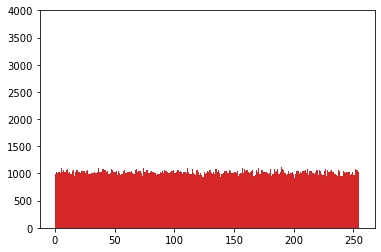

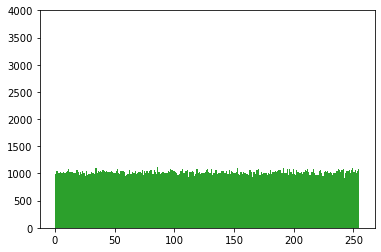

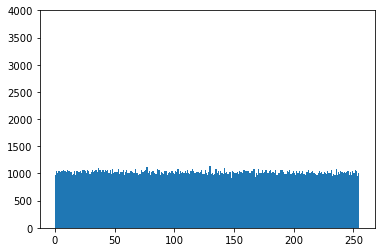

In [80]:
draw_histograms(enc_im22)

143037125
143037125
143037125


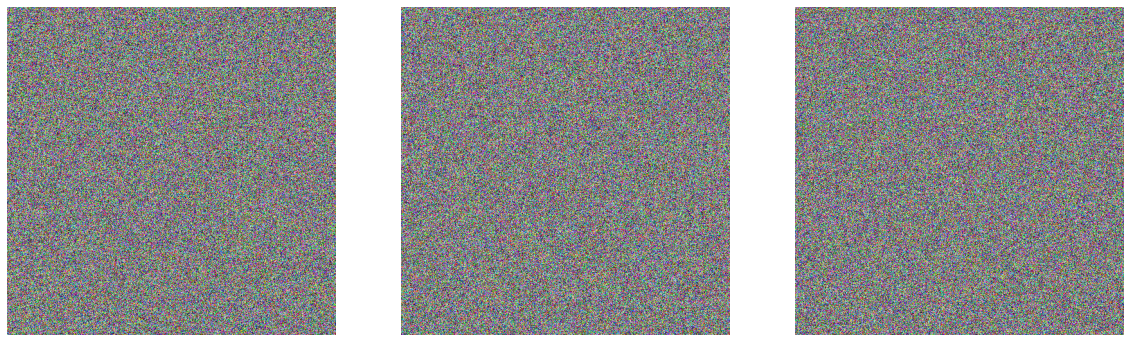

In [81]:
key_sensitivity(im22, x22, p22, 10**(-16))

In [86]:
npcr_res = npcr(im22, x22, p22)
npcr_res

143037125
143037128


[99.5888, 99.6151, 99.5964]

In [87]:
uaci_res = uaci(im22, x22, p22)
uaci_res

143037125
143037128


[32.49, 32.46, 32.39]

In [88]:
res_entropy = Entropy(enc_im22)
print(res_entropy)

[7.9991, 7.9992, 7.9993]


In [91]:
r = correlations(im22, x22, p22, 1)
r

143037125


[[0.0041, 0.006, 0.0018], [-0.002, -0.0016, 0.0015], [0.0014, 0.0021, 0.0006]]